## Tutorial 09 - Advection Dominated problem
**_Keywords: POD-Galerkin method, SUPG_**

### 1. Introduction
This tutorial addresses the POD-Galerkin method to the advection dominated worked problem in a two-dimensional domain $\Omega=(0,1)^2$.

We introduce a stabilization technique such as $\textit{Streamline/Upwind Petrov-Galerkin}$ (SUPG) able to reduce the numerical oscillations on the approximation of the solution of parametrized advection-diffusion problem:

$$
-\varepsilon(\boldsymbol{\mu})\,\Delta u(\boldsymbol{\mu})+\beta(\boldsymbol{\mu})\cdot\nabla u(\boldsymbol{\mu})=f(\boldsymbol{\mu})\quad\text{on }\,\Omega(\boldsymbol{\mu}),
$$

where $\beta(\boldsymbol{\mu})$ and $\varepsilon(\boldsymbol{\mu})$ represent the advection and the diffusion term, respectively.

For this problem, we consider on parameter $\mu$, thus $P=1$. It is related to the Péclet number:

$$
\mathbb{P}e_K(\boldsymbol{\mu})(x):=\frac{|\beta(\boldsymbol{\mu})(x)| h_K}{2\,\varepsilon(\boldsymbol{\mu})(x)}\quad\forall x\in K\quad\forall\boldsymbol{\mu}\in\mathbb{P}.
$$

Here $h_K$ represents the diameter of $K\in\mathcal{T}_h$, where $\mathcal{T}_h$ indicates a triangulation of our domain $\Omega(\boldsymbol{\mu})$.

The parameter domain is thus given by 
$$
\mathbb{P}=[0, 6].
$$

In this problem we consider two approaches:
1. Offline-Online stabilized,
2. Offline-only stabilized,

in which while in the first one we apply the SUPG method both in the Offline and Online phases, in the second one only in the Offline phase it is applied.

In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The PDE formulation of the parametrized problem is given by: for a given parameter $\mu=\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	-\frac{1}{10\,^{\boldsymbol{\mu}}}\Delta\,u(\boldsymbol{\mu})+(1,1)\cdot\nabla u(\boldsymbol{\mu})=0 & \text{in }\Omega,\\
    u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_1\cup\Gamma_2, \\ 
	u(\boldsymbol{\mu}) = 1 & \text{on } \Gamma_3\cup\Gamma_4.
\end{cases}
$$
<br>

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V},$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega): v|_{\Gamma_1\cup\Gamma_2} = 0, v|_{\Gamma_3\cup\Gamma_4} = 1\right\},
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \frac{1}{10\,^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left(\partial_xu+\partial_yu\right)v\ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu}) = \int_{\Omega} v\ d\boldsymbol{x}.$$

For the $\textit{Offline-Online stabilized}$ approach we use a different bilinear form $a_{stab}$ instead of $a$;

while in the $\textit{Offline-only stabilized}$ approach we use the the bilinear form $a_{stab}$ during the Offline phase, performing the Online Galerkin projection with respect to the bilinear form $a$,

* the parametrized bilinear stabilized form $a_{stab}(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a_{stab}(u,v,\boldsymbol{\mu}) = a(u,v,\boldsymbol{\mu}) + s(u,v,\boldsymbol{\mu}),$$

where

$$
\begin{align*}
    a(u,v;\boldsymbol{\mu}) &= \int_{\Omega} \frac{1}{10\,^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left[(1,1)\cdot\nabla u\right]v\ d\boldsymbol{x},\\
    s(u,v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K\int_K 
    \left(-\frac{1}{10\,^{\boldsymbol{\mu}}}\Delta u+(1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x},
\end{align*}
$$

and
* the parametrized linear form $f_{stab}(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$
f_{stab}(v;\boldsymbol{\mu}) = f(v;\boldsymbol{\mu}) + r(v;\boldsymbol{\mu})
$$

where

$$
\begin{align*}
    f(v;\boldsymbol{\mu}) &= \int_{\Omega} v\ d\boldsymbol{x}, \\
    r(v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K\int_K \left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}.
\end{align*}
$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
from problems import *
from reduction_methods import *
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:

$$a(u,v;\boldsymbol{\mu})=\underbrace{\frac{1}{10\,^{\boldsymbol{\mu}}}}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\left[(1,1)\cdot\nabla u\right]v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}v \ d\boldsymbol{x}}_{f_0(v)}.$$

Adding the following forms, we obtaing the affine decomposition for the stabilized approach:

$$s(u,v;\boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\frac{\delta_K}{10\,^{\boldsymbol{\mu}}}}_{\Theta^{s}_0(\boldsymbol{\mu})}\underbrace{\int_K 
    \Delta u\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_0(u,v)} \ + \
    \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{s}_1(\boldsymbol{\mu})}\underbrace{\int_K 
    \left((1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_1(u,v)},$$
$$r(v; \boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{r}_0(\boldsymbol{\mu})} \underbrace{\int_K\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{r_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class AdvectionDominated(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@OnlineStabilization()
class AdvectionDominated(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store advection and forcing expressions
        self.beta = Constant((1.0, 1.0))
        self.f = Constant(1.0)
        # Store terms related to stabilization
        self.delta = 0.5
        self.h = CellDiameter(V.mesh())

    # Return custom problem name
    def name(self):
        return "AdvectionDominated1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 10.0**(- mu[0])
            theta_a1 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_a2 = - delta * 10.0**(- mu[0])
                theta_a3 = delta
            else:
                theta_a2 = 0.0
                theta_a3 = 0.0
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "f":
            theta_f0 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_f1 = delta
            else:
                theta_f1 = 0.0
            return (theta_f0, theta_f1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            beta = self.beta
            h = self.h
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(beta, grad(u)) * v * dx
            a2 = inner(div(grad(u)), h * inner(beta, grad(v))) * dx
            a3 = inner(inner(beta, grad(u)), h * inner(beta, grad(v))) * dx
            return (a0, a1, a2, a3)
        elif term == "f":
            f = self.f
            beta = self.beta
            h = self.h
            f0 = f * v * dx
            f1 = inner(f, h * inner(beta, grad(v))) * dx
            return (f0, f1)
        elif term == "k":
            u = self.u
            k0 = inner(grad(u), grad(v)) * dx
            return (k0,)
        elif term == "m":
            u = self.u
            m0 = inner(u, v) * dx
            return (m0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P2)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 2)

### 4.3. Allocate an object of the AdvectionDominated class

In [5]:
problem = AdvectionDominated(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.0, 6.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(15)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train Greedy PDNN-PINN

In [28]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=60)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [29]:
n = 1000 # number of parameters for which we compute residuals each iteration
num_new_params = 20 # number of parameters with which we augment data each iteration
assert num_new_params <= n

# train PDNN
print("Initial training...")
pdnn_trainer.train()

new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=False
)


print("Beginning data augmentation cycles...")
for i in range(9):
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    #last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    #sample_indices = sample_indices[:last_index]
    sample_indices = sample_indices[:num_new_params]
    high_residual_params = new_parameters[sample_indices]
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=False
    )

Initial training...
0 0.31617229030025135 	Loss(validation) = 0.25002946471870585
100 0.15128038943718272 	Loss(validation) = 0.11749716601103732
200 0.13263894510677343 	Loss(validation) = 0.10736533679677691
300 0.1140053522838975 	Loss(validation) = 0.09737805234169401
400 0.09526679582023562 	Loss(validation) = 0.08767951851982292
500 0.08295055663931163 	Loss(validation) = 0.08105762028585699
600 0.07070533998607015 	Loss(validation) = 0.0715510821333509
700 0.05651162388075665 	Loss(validation) = 0.06387278958075732
800 0.04568248198891089 	Loss(validation) = 0.06034521888936524
900 0.03831236448263636 	Loss(validation) = 0.05511019773546161
1000 0.0298229717697613 	Loss(validation) = 0.04786093461035531
1100 0.02195583808147219 	Loss(validation) = 0.04078844226130105
1200 0.017810113409038604 	Loss(validation) = 0.03610104904678566
1300 0.015466683485308079 	Loss(validation) = 0.03354249904616508
1400 0.013660234729174773 	Loss(validation) = 0.03189354373274834
1500 0.0118111280

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemen

13400 0.001548778436558207 	Loss(validation) = 0.004465031469784692
13500 0.0014756089724621516 	Loss(validation) = 0.0047337909228125415
13600 0.0014039056165846683 	Loss(validation) = 0.005012404480554064
13700 0.0013336091284266557 	Loss(validation) = 0.005301088194328551
13800 0.001264709461455368 	Loss(validation) = 0.0055997076403788175
13900 0.0011972100289974036 	Loss(validation) = 0.0059082206750612
14000 0.0011311009756382934 	Loss(validation) = 0.0062276009480695515
14100 0.0010664518348220736 	Loss(validation) = 0.0065547110736302585
14200 0.0010032911716926145 	Loss(validation) = 0.006895633421027323
14300 0.0009416636723992188 	Loss(validation) = 0.0072420313114798475
14400 0.000881642639545414 	Loss(validation) = 0.00760443913149032
14500 0.0008246455229389684 	Loss(validation) = 0.007963875882561
14600 0.0007666563679724221 	Loss(validation) = 0.008354582761621593
14700 0.0007118504600763217 	Loss(validation) = 0.008744000847524958
14800 0.0006590486364773854 	Loss(vali

25300 0.00026830842316475446 	Loss(validation) = 0.0011703411319711086
25400 0.0002518243812715952 	Loss(validation) = 0.0011324480978072676
25500 0.00023586605393772066 	Loss(validation) = 0.0010965994550339907
25600 0.00022026537292892578 	Loss(validation) = 0.0010621262088390377
25700 0.0002050244066414308 	Loss(validation) = 0.0010282267133853713
25800 0.0001903019846111235 	Loss(validation) = 0.0009969654974679568
25900 0.00017651257807776963 	Loss(validation) = 0.000965458652694241
26000 0.00016400148808988412 	Loss(validation) = 0.0009387946861895752
26100 0.00015249375521657633 	Loss(validation) = 0.0009087663827052104
26200 0.00014211065099987874 	Loss(validation) = 0.0008821827136985087
26300 0.00013271873153853446 	Loss(validation) = 0.000856767447526097
26400 0.00012390680953057603 	Loss(validation) = 0.0008323795802484253
26500 0.00011589251956839617 	Loss(validation) = 0.000808557259915458
26600 0.00010850852356490768 	Loss(validation) = 0.0007848433340309337
26700 0.0001

37000 3.205885632116238e-05 	Loss(validation) = 0.0007696073629371061
37100 3.131360259915335e-05 	Loss(validation) = 0.0007559290168200973
37200 3.059899578677715e-05 	Loss(validation) = 0.0007438716344394712
37300 2.9903620048202267e-05 	Loss(validation) = 0.0007315788571642316
37400 2.9224890078465183e-05 	Loss(validation) = 0.0007194676891681141
37500 2.856490510553073e-05 	Loss(validation) = 0.0007072957422478125
37600 2.792493614698758e-05 	Loss(validation) = 0.0006956406878287511
37700 2.7303172176157852e-05 	Loss(validation) = 0.0006841103037877076
37800 2.670059149681393e-05 	Loss(validation) = 0.0006730542143258432
37900 2.6118800188859675e-05 	Loss(validation) = 0.0006616780364935734
38000 2.554789172561577e-05 	Loss(validation) = 0.0006508666561831882
38100 2.499512436518723e-05 	Loss(validation) = 0.0006405775799354792
38200 2.4481546668615105e-05 	Loss(validation) = 0.0006294151251392586
38300 2.3945198895942144e-05 	Loss(validation) = 0.0006202676416613487
38400 2.344724

48600 1.0814746595175372e-05 	Loss(validation) = 0.00029968625101490354
48700 1.0757881620407158e-05 	Loss(validation) = 0.0002986696696678557
48800 1.0702100820807998e-05 	Loss(validation) = 0.0002976669442649379
48900 1.0647190008764346e-05 	Loss(validation) = 0.0002966954695779696
49000 1.0593562309490081e-05 	Loss(validation) = 0.00029576704458755994
49100 1.0540786946403248e-05 	Loss(validation) = 0.0002948586434868524
49200 1.0489384468884283e-05 	Loss(validation) = 0.00029398100025702277
49300 1.0438256599162017e-05 	Loss(validation) = 0.00029313072849978985
49400 1.038757626779054e-05 	Loss(validation) = 0.00029213032670545765
49500 1.0338483974979022e-05 	Loss(validation) = 0.0002913507865747859
49600 1.0288682971624856e-05 	Loss(validation) = 0.0002905228084864785
49700 1.0240554073512013e-05 	Loss(validation) = 0.00028958450374427363
49800 1.0193188524631026e-05 	Loss(validation) = 0.00028882001127517824
49900 1.0146170996710546e-05 	Loss(validation) = 0.0002881043117023745


60100 1.0931022039773937e-05 	Loss(validation) = 0.00023123564412598418
60200 1.0883304931487964e-05 	Loss(validation) = 0.0002297464576566788
60300 1.0845387217199796e-05 	Loss(validation) = 0.0002284931449788709
60400 1.0812059234254575e-05 	Loss(validation) = 0.00022740249880757045
60500 1.0781642678640424e-05 	Loss(validation) = 0.00022641963014709577
60600 1.0753094450370214e-05 	Loss(validation) = 0.0002255218614615533
60700 1.0725930722656005e-05 	Loss(validation) = 0.00022468606057882438
60800 1.0699938177414854e-05 	Loss(validation) = 0.00022390912746809066
60900 1.0674527282977599e-05 	Loss(validation) = 0.00022317109359700114
61000 1.0649980532535994e-05 	Loss(validation) = 0.00022247986495817874
61100 1.0625941288774931e-05 	Loss(validation) = 0.00022181594210704948
61200 1.0602335041625756e-05 	Loss(validation) = 0.0002211890328831162
61300 1.057917789006828e-05 	Loss(validation) = 0.00022058531776893565
61400 1.0556366080597851e-05 	Loss(validation) = 0.000220007668763027

71700 9.874831242924623e-06 	Loss(validation) = 0.00018737568063218618
71800 9.866268782555925e-06 	Loss(validation) = 0.00018746360842155187
71900 9.857726606692658e-06 	Loss(validation) = 0.00018755847783033131
72000 9.849244071376845e-06 	Loss(validation) = 0.00018764376534461337
72100 9.841025662481091e-06 	Loss(validation) = 0.0001877321191777953
72200 9.832723270041484e-06 	Loss(validation) = 0.00018782683168490604
72300 9.824635753298336e-06 	Loss(validation) = 0.00018791560913272137
72400 9.816672049088472e-06 	Loss(validation) = 0.00018800243071759217
72500 9.808769467170323e-06 	Loss(validation) = 0.00018809053424052822
72600 9.800945625507805e-06 	Loss(validation) = 0.00018816720329291802
72700 9.793350055946709e-06 	Loss(validation) = 0.00018824927985237248
72800 9.785569545010492e-06 	Loss(validation) = 0.0001883322460668355
72900 9.7781500949998e-06 	Loss(validation) = 0.00018841085493216396
73000 9.770708986010725e-06 	Loss(validation) = 0.0001884725260307147
73100 9.763

83400 9.620396715962436e-06 	Loss(validation) = 0.0001860926979334748
83500 9.61704501961631e-06 	Loss(validation) = 0.00018600217724933058
83600 9.613834522201288e-06 	Loss(validation) = 0.0001859207637735885
83700 9.610649398214581e-06 	Loss(validation) = 0.0001858382355520088
83800 9.60729845692119e-06 	Loss(validation) = 0.00018576092288582907
83900 9.604268122833287e-06 	Loss(validation) = 0.0001856787788995472
84000 9.601043382397818e-06 	Loss(validation) = 0.0001855974724037259
84100 9.598027060787322e-06 	Loss(validation) = 0.0001855210493453674
84200 9.594864329437883e-06 	Loss(validation) = 0.00018544277113865179
84300 9.591775730908349e-06 	Loss(validation) = 0.00018536841911802473
84400 9.58871812839294e-06 	Loss(validation) = 0.0001852951808960174
84500 9.585700334174148e-06 	Loss(validation) = 0.0001852248336031979
84600 9.58276516140483e-06 	Loss(validation) = 0.00018516479857996887
84700 9.579742163346491e-06 	Loss(validation) = 0.00018509908937029118
84800 9.5767900050

95100 9.046539960566052e-06 	Loss(validation) = 0.00018360545805201154
95200 9.045607100898144e-06 	Loss(validation) = 0.0001836066710567013
95300 9.044556114243277e-06 	Loss(validation) = 0.00018361028642355971
95400 9.043550591617163e-06 	Loss(validation) = 0.0001836086859334871
95500 9.042613435293548e-06 	Loss(validation) = 0.00018361228893420056
95600 9.041648348046281e-06 	Loss(validation) = 0.00018361461451456014
95700 9.040729712870297e-06 	Loss(validation) = 0.0001836133248408705
95800 9.039641383482476e-06 	Loss(validation) = 0.00018361277489282524
95900 9.03876003208396e-06 	Loss(validation) = 0.0001836103618519503
96000 9.037842534242433e-06 	Loss(validation) = 0.0001836146153588919
96100 9.036900778157883e-06 	Loss(validation) = 0.00018361269213744975
96200 9.035986726906861e-06 	Loss(validation) = 0.00018360646527899516
96300 9.0350224343409e-06 	Loss(validation) = 0.00018360740623968143
96400 9.034134308175054e-06 	Loss(validation) = 0.0001836058568238207
96500 9.0333414

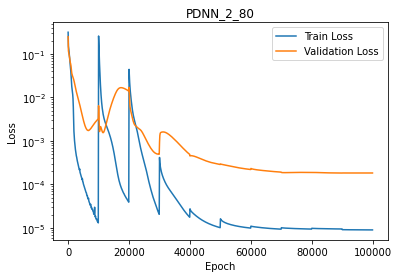

In [30]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.3 Train PRNN

In [17]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=60)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [18]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 0.3709515031674136 	Loss(validation) = 0.3331942518800942
100 0.16574447735828685 	Loss(validation) = 0.13555010407841037
200 0.14239152115362042 	Loss(validation) = 0.11697760072513151
300 0.12886157804598136 	Loss(validation) = 0.11031457319239305
400 0.11349811009737863 	Loss(validation) = 0.10299589256645901
500 0.10084994334354058 	Loss(validation) = 0.09197507889010721
600 0.08880358947167097 	Loss(validation) = 0.08219187035705809
700 0.07453215979666934 	Loss(validation) = 0.07617063547594484
800 0.0598139104857629 	Loss(validation) = 0.06891064610607735
900 0.04812475967423737 	Loss(validation) = 0.062274165421989984
1000 0.04023523407365569 	Loss(validation) = 0.0576230147707261
1100 0.033644859797442465 	Loss(validation) = 0.05369441703026003
1200 0.027741233510443806 	Loss(validation) = 0.04986988003639512
1300 0.023309862591186167 	Loss(valida

11900 9.406984390642579e-06 	Loss(validation) = 0.0006479297499683843
12000 8.957450236203357e-06 	Loss(validation) = 0.0006604849418924597
12100 8.873334675873852e-06 	Loss(validation) = 0.0006759300607816273
12200 9.595112088269849e-06 	Loss(validation) = 0.0006808887521612113
12300 1.128853128580667e-05 	Loss(validation) = 0.0007077795714332178
12400 1.2828041358815034e-05 	Loss(validation) = 0.0006871674035309896
12500 1.7341636702389856e-05 	Loss(validation) = 0.0007226776079806893
12600 7.74240697805425e-06 	Loss(validation) = 0.0007193833893216774
12700 7.563219107079501e-06 	Loss(validation) = 0.0007383011766726553
12800 7.209006135815265e-06 	Loss(validation) = 0.0007459910880457741
12900 6.650274737815781e-06 	Loss(validation) = 0.0007490511951642401
13000 6.538833331923365e-06 	Loss(validation) = 0.0007580916637787777
13100 6.364271148868724e-06 	Loss(validation) = 0.0007648492846714194
13200 1.2074508847623634e-05 	Loss(validation) = 0.0007928570600712919
13300 8.0173661976

23600 3.3287767445631318e-06 	Loss(validation) = 0.0008030533203736479
23700 7.126284692928843e-06 	Loss(validation) = 0.0008349861424788292
23800 1.9412645608010727e-06 	Loss(validation) = 0.0008105895706898433
23900 3.7129299578187694e-06 	Loss(validation) = 0.0008029093942183196
24000 3.33847985012102e-06 	Loss(validation) = 0.0007924640781649076
24100 9.59638956120103e-06 	Loss(validation) = 0.0008035252581667308
24200 1.775190983673969e-05 	Loss(validation) = 0.0007747501667360099
24300 1.7408753049358643e-05 	Loss(validation) = 0.0008024124048250262
24400 9.425808048171501e-06 	Loss(validation) = 0.000795126204856376
24500 3.289273801127983e-06 	Loss(validation) = 0.0007921472551620442
24600 2.2961246877392067e-06 	Loss(validation) = 0.000790958504946143
24700 7.29219286663778e-06 	Loss(validation) = 0.0007747045395441281
24800 1.9131172838250144e-06 	Loss(validation) = 0.0007832366237108896
24900 2.359184331763933e-06 	Loss(validation) = 0.000777012004321571
25000 1.928907625692

35300 8.16317127180148e-06 	Loss(validation) = 0.0007884398260945315
35400 1.0759330852356041e-06 	Loss(validation) = 0.0007897278849123903
35500 1.0831964573676898e-06 	Loss(validation) = 0.0007893330336809411
35600 1.681960425843678e-06 	Loss(validation) = 0.0007800857820059255
35700 5.335913880576541e-06 	Loss(validation) = 0.0007836783822758128
35800 5.644554636890433e-06 	Loss(validation) = 0.0007873253532421486
35900 2.2143172743854825e-06 	Loss(validation) = 0.0007865942080080457
36000 2.593807362031186e-06 	Loss(validation) = 0.0007762114751112903
36100 1.0261653381168758e-05 	Loss(validation) = 0.0008042738362540613
36200 4.682115192693063e-06 	Loss(validation) = 0.0008075184403302455
36300 1.3374251710000009e-06 	Loss(validation) = 0.0007957328620622902
36400 9.656440281560156e-07 	Loss(validation) = 0.0007921002646465438
36500 1.0376186105828273e-06 	Loss(validation) = 0.0007982364065873695
36600 2.9315899093466653e-06 	Loss(validation) = 0.0008014393078505094
36700 1.648656

47000 1.0812798840284053e-06 	Loss(validation) = 0.0008754750027690491
47100 8.253272181332711e-07 	Loss(validation) = 0.0008713003704853493
47200 8.909579920115637e-06 	Loss(validation) = 0.0008747405409773898
47300 2.8444762974390523e-06 	Loss(validation) = 0.000860738291089556
47400 3.5187133634537477e-06 	Loss(validation) = 0.0008687259603102842
47500 9.529656110223314e-07 	Loss(validation) = 0.000872479426354077
47600 1.3401816784329428e-06 	Loss(validation) = 0.000878699373599443
47700 1.0295823305165303e-06 	Loss(validation) = 0.0008852210321148899
47800 2.776949289632618e-06 	Loss(validation) = 0.0008713011802105501
47900 9.407315718602668e-07 	Loss(validation) = 0.0008837643202092624
48000 3.931007928396458e-06 	Loss(validation) = 0.0008808747482736962
48100 6.752497006846235e-07 	Loss(validation) = 0.0008759766453494798
48200 1.5745094703343901e-06 	Loss(validation) = 0.0008788238688018472
48300 7.554321586177711e-07 	Loss(validation) = 0.0008843293651362755
48400 5.203671505

58700 3.1992387754401865e-06 	Loss(validation) = 0.0009342556461380223
58800 1.9818284799558025e-06 	Loss(validation) = 0.0009374712161251412
58900 6.681784788294867e-07 	Loss(validation) = 0.0009357416583674938
59000 1.8544693899289374e-06 	Loss(validation) = 0.0009374518933333903
59100 1.112424179678628e-06 	Loss(validation) = 0.0009327894982157385
59200 1.055453839779908e-06 	Loss(validation) = 0.0009291513728929845
59300 8.234958357011456e-07 	Loss(validation) = 0.0009326563413970339
59400 1.721433072367944e-06 	Loss(validation) = 0.0009389906273355662
59500 7.120853920093054e-07 	Loss(validation) = 0.0009377154273317332
59600 3.8218457585705865e-06 	Loss(validation) = 0.0009260955349197815
59700 5.249577662880362e-07 	Loss(validation) = 0.0009390538138979851
59800 1.1474912838767607e-06 	Loss(validation) = 0.000933534640671138
59900 1.4127630861233674e-06 	Loss(validation) = 0.000941889631861671
60000 6.3213050894810775e-06 	Loss(validation) = 0.0009578193904325343
60100 4.2891481

70400 5.125395130343184e-07 	Loss(validation) = 0.0009775309988706413
70500 6.199120757735518e-07 	Loss(validation) = 0.000977389225415941
70600 4.427038869091063e-07 	Loss(validation) = 0.0009781704265646584
70700 8.299455296448841e-07 	Loss(validation) = 0.000988202086386447
70800 9.064353871176216e-07 	Loss(validation) = 0.0009842842969992362
70900 1.245626082251324e-06 	Loss(validation) = 0.0009773616435231219
71000 4.778417308945354e-07 	Loss(validation) = 0.0009840241358552715
71100 7.703169248682191e-07 	Loss(validation) = 0.0009904035890077245
71200 9.590857802063081e-07 	Loss(validation) = 0.0009767686720828777
71300 2.3445530258702405e-06 	Loss(validation) = 0.000993302103647367
71400 1.6651273926011598e-06 	Loss(validation) = 0.0009796396383068868
71500 1.8980476049046976e-06 	Loss(validation) = 0.0009871832478748164
71600 9.132060403785008e-07 	Loss(validation) = 0.0009904348621170456
71700 4.4670956507607517e-07 	Loss(validation) = 0.0009834095030885942
71800 4.18067416765

82100 7.888003952885606e-07 	Loss(validation) = 0.0010287251366802204
82200 5.645816840629391e-07 	Loss(validation) = 0.0010299540722071635
82300 7.500593695962533e-07 	Loss(validation) = 0.0010233078756419517
82400 1.8424352690075332e-06 	Loss(validation) = 0.0010223421370580573
82500 5.039278716219934e-07 	Loss(validation) = 0.0010262192288541545
82600 5.099360437626595e-07 	Loss(validation) = 0.0010244487774152186
82700 6.304517900827407e-07 	Loss(validation) = 0.0010267682265662503
82800 7.492336192123262e-07 	Loss(validation) = 0.0010261474087103772
82900 5.698875483131883e-07 	Loss(validation) = 0.0010310603211417283
83000 4.7680577193950767e-07 	Loss(validation) = 0.0010269300192045452
83100 1.1887338001800495e-06 	Loss(validation) = 0.0010276977475226826
83200 1.956084902736642e-06 	Loss(validation) = 0.0010322548826351137
83300 6.863686658827075e-07 	Loss(validation) = 0.0010217640944631464
83400 8.297724152661215e-07 	Loss(validation) = 0.0010291863250471392
83500 6.848378803

93800 3.724130220366877e-07 	Loss(validation) = 0.0010600975860364343
93900 1.8722098176164225e-06 	Loss(validation) = 0.0010637444114330115
94000 7.345673223942601e-07 	Loss(validation) = 0.0010707065889534568
94100 7.798152785484799e-07 	Loss(validation) = 0.0010654135258528195
94200 5.276752591706959e-07 	Loss(validation) = 0.0010680793328084932
94300 3.7923177045306506e-07 	Loss(validation) = 0.0010661815206955264
94400 5.74099011741816e-07 	Loss(validation) = 0.0010688241228730317
94500 5.023100629985807e-07 	Loss(validation) = 0.0010706917331850456
94600 6.459024842531237e-07 	Loss(validation) = 0.001071951747645568
94700 3.0477696062191388e-06 	Loss(validation) = 0.0010709513259648678
94800 4.659355687156478e-07 	Loss(validation) = 0.0010634749313457774
94900 4.1678207680816553e-07 	Loss(validation) = 0.0010641276208633818
95000 7.462990084054437e-07 	Loss(validation) = 0.0010591981579797997
95100 7.579594590095888e-07 	Loss(validation) = 0.0010747568778708332
95200 3.7370452980

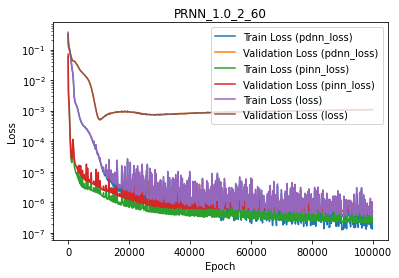

In [19]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

#### 4.5.4 Train PINN

In [21]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=275)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [22]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 0.04163254136412394 	Loss(validation) = 0.044717727394300195
100 0.003742343110357579 	Loss(validation) = 0.004342770622413931
200 0.0023432559716383534 	Loss(validation) = 0.002881722514386438
300 0.0014065904820580412 	Loss(validation) = 0.0018327315865516592
400 0.0010268981942430902 	Loss(validation) = 0.001333196792781371
500 0.0006998838423691226 	Loss(validation) = 0.0008843737356877921
600 0.00044567333630299213 	Loss(validation) = 0.0005447392409870217
700 0.00028300447198089404 	Loss(validation) = 0.0003355686515740065
800 0.0001843650113994658 	Loss(validation) = 0.0002140154287892126
900 0.00013002812221281945 	Loss(validation) = 0.00014831241028884294
1000 0.00010219106701193766 	Loss(validation) = 0.00011486234279783152
1100 8.741189583767953e-05 	Loss(validation) = 9.727481222971124e-05
1200 7.807597731357085e-05 	Loss(validation) = 8.636448

11600 6.66189022880381e-07 	Loss(validation) = 7.788346657529685e-07
11700 6.97582455238367e-07 	Loss(validation) = 7.7150202753572e-07
11800 1.1547874777581247e-06 	Loss(validation) = 1.2061361390811797e-06
11900 6.342523428084196e-07 	Loss(validation) = 7.412557694064091e-07
12000 3.3340045896142126e-06 	Loss(validation) = 8.128141021343114e-06
12100 6.149168443454598e-07 	Loss(validation) = 7.191053275818294e-07
12200 6.064126970544713e-07 	Loss(validation) = 7.045244225644361e-07
12300 5.952908718096185e-07 	Loss(validation) = 6.952971416638132e-07
12400 6.200704378481704e-07 	Loss(validation) = 7.439565657652693e-07
12500 5.974475472519488e-07 	Loss(validation) = 7.240078848872389e-07
12600 5.682053253792726e-07 	Loss(validation) = 6.631094637340697e-07
12700 8.445038049365254e-07 	Loss(validation) = 1.3328888773605832e-06
12800 6.160127792751423e-07 	Loss(validation) = 7.535278176939358e-07
12900 9.27116578453828e-07 	Loss(validation) = 9.687901682555145e-07
13000 5.3420960036166

23300 2.109579743241565e-07 	Loss(validation) = 2.3150102103040417e-07
23400 1.9009612580310506e-07 	Loss(validation) = 1.914089048416954e-07
23500 1.8670875149630575e-07 	Loss(validation) = 1.905133427210368e-07
23600 1.81814168884634e-07 	Loss(validation) = 1.8415732613263794e-07
23700 1.8207179239196175e-07 	Loss(validation) = 1.8672494548684133e-07
23800 1.8028652834994445e-07 	Loss(validation) = 1.8333870880589655e-07
23900 1.8078864720961938e-07 	Loss(validation) = 1.8603903467361103e-07
24000 2.6184610045396865e-07 	Loss(validation) = 2.5166926203429525e-07
24100 1.9344056727011193e-07 	Loss(validation) = 2.1091047205048977e-07
24200 1.7589300060767192e-07 	Loss(validation) = 1.7741071979828005e-07
24300 1.755132130955161e-07 	Loss(validation) = 1.7725473209144625e-07
24400 1.762024875731353e-07 	Loss(validation) = 1.774090166925013e-07
24500 2.4653968256661903e-07 	Loss(validation) = 2.8884251709054174e-07
24600 9.504676524856153e-07 	Loss(validation) = 1.4808240585051536e-06
2

34800 1.7585375004404005e-07 	Loss(validation) = 1.8189371007803755e-07
34900 4.0580128761913074e-07 	Loss(validation) = 6.066120952612064e-07
35000 1.1524909893633952e-07 	Loss(validation) = 1.1492873552691314e-07
35100 1.1686182482305048e-07 	Loss(validation) = 1.1866490694851892e-07
35200 1.1419717977097074e-07 	Loss(validation) = 1.1488089179861927e-07
35300 1.1375590926514596e-07 	Loss(validation) = 1.1420760351917299e-07
35400 1.1392174164948299e-07 	Loss(validation) = 1.1439901661744896e-07
35500 3.149834246786024e-07 	Loss(validation) = 5.034505940321039e-07
35600 7.476680519100499e-07 	Loss(validation) = 9.233256470306815e-07
35700 1.6834132050147702e-07 	Loss(validation) = 2.3169056713761622e-07
35800 1.1240127136030609e-07 	Loss(validation) = 1.1404131366761549e-07
35900 1.6139244130289181e-07 	Loss(validation) = 2.2091979719352053e-07
36000 1.481973830280104e-07 	Loss(validation) = 1.7397304042456513e-07
36100 1.4204057935101903e-07 	Loss(validation) = 1.6738991013225986e-0

46400 8.468007798991481e-08 	Loss(validation) = 8.716333815493406e-08
46500 8.442884393560199e-08 	Loss(validation) = 8.680401563173634e-08
46600 8.889671550007458e-08 	Loss(validation) = 9.361283639190524e-08
46700 1.9726952977232623e-07 	Loss(validation) = 3.1960275629180457e-07
46800 9.442251607697796e-08 	Loss(validation) = 1.0501596864826417e-07
46900 2.8167822212932496e-07 	Loss(validation) = 3.369699531087366e-07
47000 8.369852079645316e-08 	Loss(validation) = 8.667020432424137e-08
47100 8.563360402368216e-08 	Loss(validation) = 9.270184197129703e-08
47200 8.628343316167262e-08 	Loss(validation) = 9.076926173910158e-08
47300 8.481972826032342e-08 	Loss(validation) = 8.649798453076166e-08
47400 9.339682198461892e-08 	Loss(validation) = 9.754442468015762e-08
47500 2.9426838758258876e-07 	Loss(validation) = 4.0708161558901845e-07
47600 1.0922081607133827e-07 	Loss(validation) = 1.5684753307689363e-07
47700 9.310216408592404e-08 	Loss(validation) = 1.0323742649190881e-07
47800 9.033

58100 6.642414751302613e-08 	Loss(validation) = 6.988907273214454e-08
58200 7.821858252374682e-08 	Loss(validation) = 9.026718402408906e-08
58300 9.44303829526429e-08 	Loss(validation) = 9.919947511668492e-08
58400 1.547714327423443e-07 	Loss(validation) = 2.680305327668177e-07
58500 6.54553848767246e-08 	Loss(validation) = 6.930850872928854e-08
58600 6.549881398633706e-08 	Loss(validation) = 6.977723238818176e-08
58700 6.558115521838004e-08 	Loss(validation) = 6.914490732944273e-08
58800 7.090664347518433e-08 	Loss(validation) = 7.587547280311512e-08
58900 1.8881855739772697e-07 	Loss(validation) = 2.815878024417999e-07
59000 6.557840716599305e-08 	Loss(validation) = 7.045564473566459e-08
59100 7.043004865390194e-08 	Loss(validation) = 7.964452757453318e-08
59200 6.51771375637783e-08 	Loss(validation) = 7.001643325368214e-08
59300 6.545858529739018e-08 	Loss(validation) = 6.87724591749493e-08
59400 1.704586536592258e-07 	Loss(validation) = 1.2988404622355381e-07
59500 6.42079473629158

69800 5.472898810991037e-08 	Loss(validation) = 6.130839976749924e-08
69900 5.579244399723119e-08 	Loss(validation) = 6.135894510644074e-08
70000 5.3282916530992455e-08 	Loss(validation) = 5.7898914526019676e-08
70100 5.390284244628109e-08 	Loss(validation) = 5.790846021265318e-08
70200 8.042276260048888e-08 	Loss(validation) = 1.0360034636303262e-07
70300 5.455094747231956e-08 	Loss(validation) = 6.229583771432792e-08
70400 9.453117104932387e-08 	Loss(validation) = 1.161082031523657e-07
70500 5.472063881511704e-08 	Loss(validation) = 5.905528322279686e-08
70600 5.2821717911773046e-08 	Loss(validation) = 5.749621265363133e-08
70700 5.282450459635519e-08 	Loss(validation) = 5.761691271481094e-08
70800 5.3357017495051286e-08 	Loss(validation) = 5.784561822842497e-08
70900 6.179815451426693e-08 	Loss(validation) = 6.471872143022592e-08
71000 5.264942959805744e-08 	Loss(validation) = 5.754281775422665e-08
71100 5.379295523944125e-08 	Loss(validation) = 6.005878865191538e-08
71200 5.9076619

81500 4.677176883386051e-08 	Loss(validation) = 5.1354301311479695e-08
81600 4.460551270736346e-08 	Loss(validation) = 4.9397919257978496e-08
81700 4.683874888361215e-08 	Loss(validation) = 5.2947906173104426e-08
81800 6.725390907047853e-08 	Loss(validation) = 7.819478902656771e-08
81900 4.5439130786933064e-08 	Loss(validation) = 5.0860314723928144e-08
82000 6.862620490166193e-08 	Loss(validation) = 9.800681175840763e-08
82100 9.311638464591911e-08 	Loss(validation) = 1.117999418540228e-07
82200 1.0734822559299645e-07 	Loss(validation) = 1.3566525971672336e-07
82300 4.5193737817098e-08 	Loss(validation) = 4.937089100946634e-08
82400 6.156822689083567e-08 	Loss(validation) = 6.743690272064045e-08
82500 4.494626800653955e-08 	Loss(validation) = 4.9955399930996105e-08
82600 5.45251503131516e-08 	Loss(validation) = 6.922055503947729e-08
82700 2.0969144310771778e-07 	Loss(validation) = 3.287355079767078e-07
82800 4.681150889004583e-08 	Loss(validation) = 6.568838261242849e-08
82900 5.200109

93200 3.990703032239438e-08 	Loss(validation) = 4.6196924560339554e-08
93300 7.020343789086417e-08 	Loss(validation) = 9.979910492284245e-08
93400 5.149509904480567e-08 	Loss(validation) = 5.098132173689036e-08
93500 3.959298786477245e-08 	Loss(validation) = 4.8097647569761994e-08
93600 5.8766549208311367e-08 	Loss(validation) = 8.596561046295329e-08
93700 1.0922651088868779e-07 	Loss(validation) = 1.0721435093262848e-07
93800 4.549842379239135e-08 	Loss(validation) = 5.467210469568469e-08
93900 5.0888550201677005e-08 	Loss(validation) = 5.843338868948774e-08
94000 3.9799118147989e-08 	Loss(validation) = 4.570969376946733e-08
94100 5.6159348534742056e-08 	Loss(validation) = 7.283095971110963e-08
94200 3.9355053718936854e-08 	Loss(validation) = 4.534536145807384e-08
94300 5.639823999010343e-08 	Loss(validation) = 8.585575576170487e-08
94400 5.198539766275739e-08 	Loss(validation) = 6.296531947857366e-08
94500 4.804036703950733e-08 	Loss(validation) = 5.681309178255967e-08
94600 3.751045

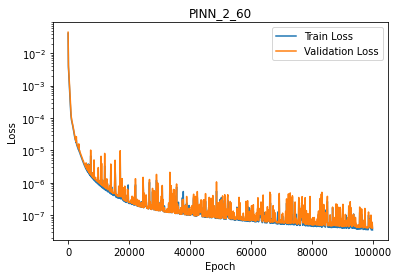

In [23]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

In [11]:
np.random.seed(42)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

#### 4.6.1 Greedy PDNN-PINN Error Analysis

In [32]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	1.6983415228020817e-05	1.7190842985792702e-05	5.435570216244983e-07
mean	0.0005138141770429719	0.0004978366052002905	4.867435599142324e-05
max	0.004613570608504875	0.004601965778549217	0.00045783120132054483


#### 4.6.2 PRNN Error Analysis

In [26]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00016899515413882092	0.00016895509971614846	5.435570216244983e-07
mean	0.009522778036543533	0.00952563038553222	4.867435599142324e-05
max	0.05456147096519454	0.0546087552225331	0.00045783120132054483


#### 4.6.3 PINN Error Analysis

In [27]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0008230987848671062	0.0008246106670970045	5.435570216244983e-07
mean	0.0036184910156598143	0.0036188630368077374	4.867435599142324e-05
max	0.0074084970750823015	0.00740780110614341	0.00045783120132054483
